# Topic Modeling to Classification Modeling
Since our data is not grouped, we will begin by building a topic model. We will adjust that model as necessary until we feel satisfied with the topics discovered. We will subset our data to the topics we feel most comfortable with and use that resulting data set to build a classification model. 

Once that is complete we will report the accuracy of our classification model against a hold-out test set. 

You should find a data set that is organized into groups or that can be classified via topic modeling. The steps of your final project will vary depending on whether or not your data are grouped. If your data are grouped, then you will begin by building a classification model and reporting the accuracy of your model against a hold-out test set. Then you will ignore the groups and build a topic model such as NMF, LSA, or LDA to put the data into groups. You will then compare how well those topics agree with the a priori groups.  

## Import Libraries

In [164]:
# Import Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter 
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from ast import literal_eval

# # Some punctuation variations
# punctuation = set(punctuation) # speeds up comparison

# # Stopwords
# sw = stopwords.words("english")

import warnings  
warnings.filterwarnings('ignore')


## Helper Functions

## Data ETL and EDA

In [165]:
# Get Imported Data
arxiv_data = pd.read_pickle('G:\\My Drive\\ADS-509_Final_Team_Project\\arxiv_data_2023_02_13.pkl')
arxiv_data

,titles,abstracts,terms
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG]
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]"
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG]
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]"
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]"
...,...,...,...
64568,Plot 94 in ambiance X-Window,<PLOT > is a collection of routines to draw su...,"[cs.CV, cs.GR]"
64569,Automatic Face Recognition System Based on Loc...,We present an automatic face verification syst...,[cs.CV]
64570,Convexity Analysis of Snake Models Based on Ha...,This paper presents a convexity analysis for t...,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]"
64571,Semi-automatic vectorization of linear network...,A system for semi-automatic vectorization of l...,"[cs.CV, cs.MM, I.4.6]"


In [217]:
# Data Review
print(f"There are {len(arxiv_data)} rows in the dataset.\n")

total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicated titles.\n")

dedup_arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()].reset_index()
print(f"There are {len(dedup_arxiv_data)} rows in the deduplicated dataset.\n")

# There are some terms with occurrence as low as 1.
occur = sum(dedup_arxiv_data["terms"].value_counts() == 1)
print(f"There are {occur} terms with an occurrence of 1.\n")

# How many unique terms?
unique_terms = dedup_arxiv_data["terms"].astype('str').nunique()
print(f"There are {unique_terms} unique terms.\n")

There are 64573 rows in the dataset.

There are 14237 duplicated titles.

There are 50336 rows in the deduplicated dataset.

There are 2907 terms with an occurrence of 1.

There are 3961 unique terms.



In [218]:
columns = ['category_1', 'category_2', 'category_3',
          'category_4', 'category_5', 'category_6',
          'category_7', 'category_8', 'category_9',
          'category_10', 'category_11']

# Melt the categories
df = dedup_arxiv_data.terms.apply(pd.Series, name="cat")

# Name the columns
df.columns = columns

df

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11
0,cs.LG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stat.ML,cs.LG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cs.LG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cs.LG,cs.AI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,stat.ML,cs.CV,cs.IT,cs.LG,math.IT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
50331,cs.CV,cs.GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50332,cs.CV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50333,cs.CV,cs.GR,I.4; I.4.6;I.4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50334,cs.CV,cs.MM,I.4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
# x = description_category_new[description_category_new['test']==0][['terms','stat.ML']]
columns = ['category_1', 'category_2', 'category_3',
          'category_4', 'category_5', 'category_6',
          'category_7', 'category_8', 'category_9',
          'category_10', 'category_11']
cat1 = pd.DataFrame(dedup_arxiv_data['terms'].to_list(), columns = columns)
cat1
cat1['test'] = cat1.sum(axis=1)
x = cat1[cat1['test']==0]
# x
# e = pd.concat([x['terms'], x['stat.ML'],  cat1.iloc[:]], axis=1)
# e

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11
0,cs.LG,None,None,None,None,None,None,None,None,None,None
1,stat.ML,cs.LG,None,None,None,None,None,None,None,None,None
2,cs.LG,None,None,None,None,None,None,None,None,None,None
3,cs.LG,cs.AI,None,None,None,None,None,None,None,None,None
4,stat.ML,cs.CV,cs.IT,cs.LG,math.IT,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
50331,cs.CV,cs.GR,None,None,None,None,None,None,None,None,None
50332,cs.CV,None,None,None,None,None,None,None,None,None,None
50333,cs.CV,cs.GR,I.4; I.4.6;I.4.8,None,None,None,None,None,None,None,None
50334,cs.CV,cs.MM,I.4.6,None,None,None,None,None,None,None,None


In [167]:
columns = ['category_1', 'category_2', 'category_3',
          'category_4', 'category_5', 'category_6',
          'category_7', 'category_8', 'category_9',
          'category_10', 'category_11']
cat = pd.DataFrame(dedup_arxiv_data['terms'].to_list(), columns = columns)
cat

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11
0,cs.LG,None,None,None,None,None,None,None,None,None,None
1,stat.ML,cs.LG,None,None,None,None,None,None,None,None,None
2,cs.LG,None,None,None,None,None,None,None,None,None,None
3,cs.LG,cs.AI,None,None,None,None,None,None,None,None,None
4,stat.ML,cs.CV,cs.IT,cs.LG,math.IT,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
50331,cs.CV,cs.GR,None,None,None,None,None,None,None,None,None
50332,cs.CV,None,None,None,None,None,None,None,None,None,None
50333,cs.CV,cs.GR,I.4; I.4.6;I.4.8,None,None,None,None,None,None,None,None
50334,cs.CV,cs.MM,I.4.6,None,None,None,None,None,None,None,None


In [168]:
cat.isnull().values.any()

True

In [169]:
cat.isnull().sum()

category_1         0
category_2     19419
category_3     36251
category_4     45815
category_5     48991
category_6     50014
category_7     50277
category_8     50326
category_9     50333
category_10    50335
category_11    50335
dtype: int64

In [170]:
cat

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11
0,cs.LG,None,None,None,None,None,None,None,None,None,None
1,stat.ML,cs.LG,None,None,None,None,None,None,None,None,None
2,cs.LG,None,None,None,None,None,None,None,None,None,None
3,cs.LG,cs.AI,None,None,None,None,None,None,None,None,None
4,stat.ML,cs.CV,cs.IT,cs.LG,math.IT,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
50331,cs.CV,cs.GR,None,None,None,None,None,None,None,None,None
50332,cs.CV,None,None,None,None,None,None,None,None,None,None
50333,cs.CV,cs.GR,I.4; I.4.6;I.4.8,None,None,None,None,None,None,None,None
50334,cs.CV,cs.MM,I.4.6,None,None,None,None,None,None,None,None


In [171]:
uniqueValues = []
for columnName in cat:
    categories = cat[columnName].unique().tolist()
    categories = [x for x in categories if x is not None]
    uniqueValues.extend(categories)
    uniqueValues = list(set(uniqueValues))

len(uniqueValues)

1381

In [172]:
cat = pd.concat([cat,pd.DataFrame(columns = list(uniqueValues))])
cat.fillna(0, inplace = True)
cat.head()

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,I.5.1; I.4.6; I.3.7,I.5.4,F.2.1,I.2.8; I.2.9; I.2.6,"05B45, 62H30, 54E05, 68T10",J.4; I.2.4,I.2.6; I.2.10; I.5.0; J.4,"34A55, 68T07, 90C30, 65L09",68T07 (Primary) 68T05 (Secondary),cond-mat.other
0,cs.LG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,stat.ML,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cs.LG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cs.LG,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,stat.ML,cs.CV,cs.IT,cs.LG,math.IT,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
# Mark each of the categories with 1 if they exist.

# columns1 = ['category_1']

for col in columns:
    row = 0
    for row, category in enumerate(cat[col]):
        # print(category)
        if category != 0:
            cat.loc[row, category] = 1


In [206]:
# Create New Dataframe with dummies appended.
description_category_new = pd.concat([dedup_arxiv_data['titles'],dedup_arxiv_data['abstracts'], 
dedup_arxiv_data['terms'], cat.iloc[:,11:]],
                                    axis=1)
description_category_new.head()

,titles,abstracts,terms,"Artificial intelligence, Machine learning, Deep learning",G.1.6; F.2.1,"68T45, 62F35",I.4.8; I.4.10; I.4.6; I.3.5; J.6,I.3.3; I.2.10,"68T40, 68T07, 68T05",C.1.3,...,I.5.1; I.4.6; I.3.7,I.5.4,F.2.1,I.2.8; I.2.9; I.2.6,"05B45, 62H30, 54E05, 68T10",J.4; I.2.4,I.2.6; I.2.10; I.5.0; J.4,"34A55, 68T07, 90C30, 65L09",68T07 (Primary) 68T05 (Secondary),cond-mat.other
0,Reinforcement Learning from Multiple Sensors v...,"In many scenarios, observations from more than...",[cs.LG],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Interventional Causal Representation Learning,Causal representation learning seeks to extrac...,"[stat.ML, cs.LG]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Self-Supervised Node Representation Learning v...,Self-supervised node representation learning a...,[cs.LG],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Out-of-Distribution Representation Learning fo...,Time series classification is an important pro...,"[cs.LG, cs.AI]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Trading Information between Latents in Hierarc...,Variational Autoencoders (VAEs) were originall...,"[stat.ML, cs.CV, cs.IT, cs.LG, math.IT]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
description_category_new['test'] = description_category_new.iloc[:,3:].sum(axis=1)


description_category_new[description_category_new['test']==0][['terms','stat.ML']]

,terms,stat.ML
50336,"[stat.ML, cs.CV, cs.LG, q-fin.GN]",NaN
50337,[cs.CV],NaN
50338,"[cs.LG, stat.ML, 68T07, I.2.0]",NaN
50341,"[cs.LG, cs.SD, eess.AS]",NaN
50342,[cs.CV],NaN
...,...,...
64568,"[cs.CV, cs.GR]",NaN
64569,[cs.CV],NaN
64570,"[cs.CV, cs.GR, I.4; I.4.6;I.4.8]",NaN
64571,"[cs.CV, cs.MM, I.4.6]",NaN


In [182]:
# Let's get the columns with the highest counts
bar_plot = pd.DataFrame()
bar_plot['cat'] = description_category_new.columns[3:]
bar_plot['count'] = description_category_new.iloc[:,3:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head()

,cat,count
0,cs.LG,28902.0
1,cs.CV,27981.0
2,stat.ML,11087.0
3,cs.AI,10249.0
4,cs.RO,2037.0


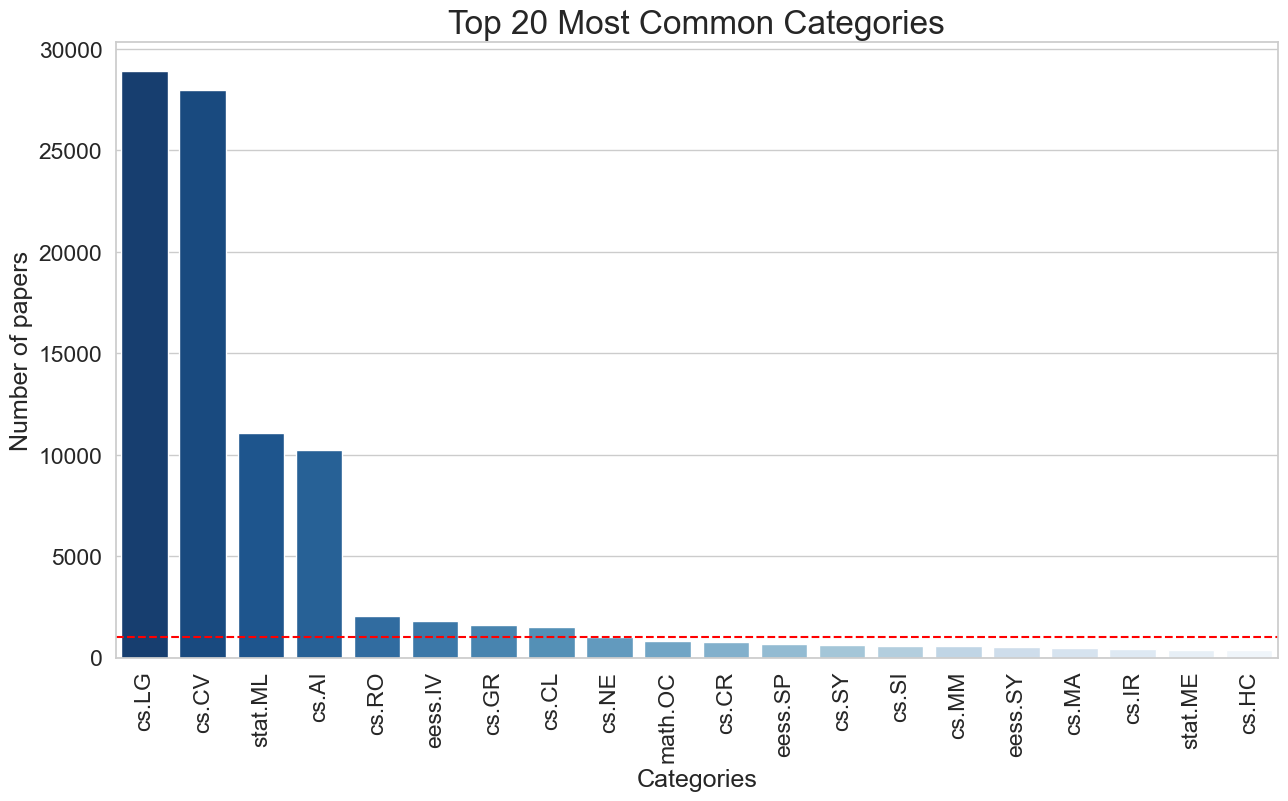

In [176]:
# Plot the Top N Most Common Categories.

top_n = 20
threshold = 1000

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot.head(top_n)))
rank = bar_plot['count'].head(top_n).argsort().argsort()  

sns.barplot(data = bar_plot.head(top_n), x='cat', y = 'count', palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title(f"Top {top_n} Most Common Categories", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('Categories', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

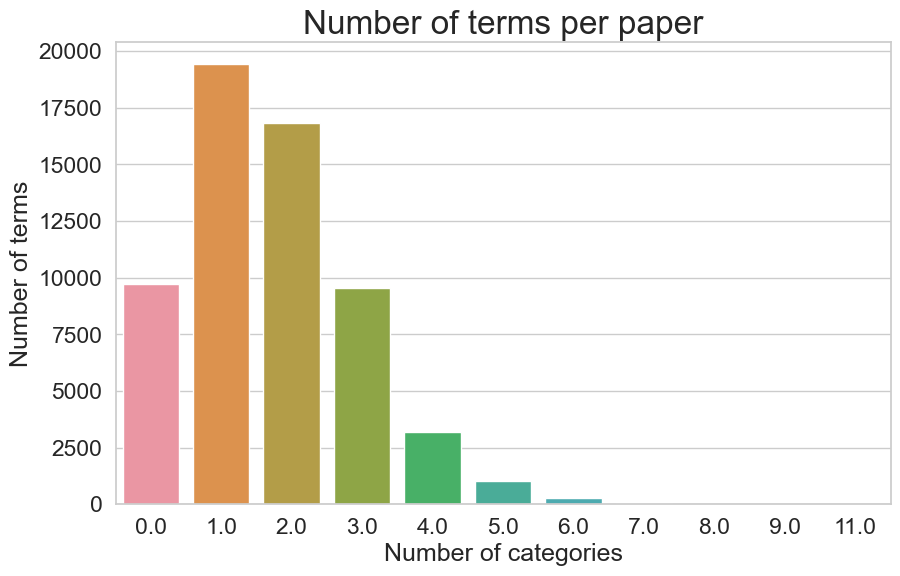

In [178]:
rowSums = description_category_new.iloc[:,3:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot( x = multiLabel_counts.index, y = multiLabel_counts.values)
plt.title("Number of terms per paper", fontsize=24)
plt.ylabel('Number of terms', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

plt.show()

In [163]:
main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>1000]
categories = main_categories['cat'].values
categories = np.append(categories,'Others')
not_category = []
description_category_new['Others'] = 0

for i in description_category_new.columns[3:]:
    if i not in categories:
        description_category_new['Others'][description_category_new[i] == 1] = 1
        not_category.append(i)

description_category_new.drop(not_category, axis=1, inplace=True)


In [151]:
y = description_category_new.columns[3:]
y

Index(['Artificial intelligence, Machine learning, Deep learning',
       'G.1.6; F.2.1', '68T45, 62F35', 'I.4.8; I.4.10; I.4.6; I.3.5; J.6',
       'I.3.3; I.2.10', '68T40, 68T07, 68T05', 'C.1.3', 'math.MG',
       '90C26, 62F35', 'I.6.3; I.3.7',
       ...
       'I.5.1; I.4.6; I.3.7', 'I.5.4', 'F.2.1', 'I.2.8; I.2.9; I.2.6',
       '05B45, 62H30, 54E05, 68T10', 'J.4; I.2.4', 'I.2.6; I.2.10; I.5.0; J.4',
       '34A55, 68T07, 90C30, 65L09', '68T07 (Primary) 68T05 (Secondary)',
       'cond-mat.other'],
      dtype='object', length=1381)

In [154]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(description_category_new.columns[3:])
y

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [155]:
multilabel.classes_

array(['\n', ' ', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
       'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
       'w', 'x', 'y'], dtype=object)

In [159]:
description_category_new.describe().T

,count,mean,std,min,25%,50%,75%,max
"Artificial intelligence, Machine learning, Deep learning",50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
G.1.6; F.2.1,50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
"68T45, 62F35",50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
I.4.8; I.4.10; I.4.6; I.3.5; J.6,50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
I.3.3; I.2.10,50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
J.4; I.2.4,50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
I.2.6; I.2.10; I.5.0; J.4,50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
"34A55, 68T07, 90C30, 65L09",50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0
68T07 (Primary) 68T05 (Secondary),50336.0,0.00002,0.004457,0.0,0.0,0.0,0.0,1.0


## Test Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(description_category_new['summaries'], 
                                                    description_category_new[description_category_new.columns[3:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[4], 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## Classification Modeling

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# Logistic Regression

LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
accuracy = 0
for category in description_category_new.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(description_category_new.columns[2:])))

In [ ]:
# Multinomial Naive Bayes

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))])
accuracy = 0
for category in description_category_new.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(description_category_new.columns[2:])))

## Topic Modeling